In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Understanding the Data
Before we start cleaning data for a machine learning project, it is vital to understand what the data is, and what we want to achieve. Without that understanding, we have no basis from which to make decisions about what data is relevant as we clean and prepare our data.

We’ll be working with some data from Lending Club, a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower’s credit score using past historical data and assigns an interest rate to the borrower.

Approved loans are listed on the Lending Club website, where qualified investors can browse recently approved loans, the borrower’s credit score, the purpose for the loan, and other information from the application.

Once an investor decides to fund a loan, the borrower then makes monthly payments back to Lending Club. Lending Club redistributes these payments to investors. This means that investors don’t have to wait until the full amount is paid off to start to see returns. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition to the requested amount.

Many loans aren’t completely paid off on time, however, and some borrowers default on the loan. That’s the problem we’ll be trying to address as we clean some data from Lending Club for machine learning. Let’s imagine we’ve been tasked with building a model to predict whether borrowers are likely to pay or default on their loans.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We’ve downloaded our data set and named it lending_club_loans.csv, but now we need to load it into a pandas DataFrame to explore it. Once it’s loaded, we’ll want to do some basic cleaning tasks to remove some information we don’t need that will make our data processing slower.

Specifically, we’re going to:

 

*   Remove the first line: It contains extraneous text instead of the column titles. This text prevents the data set from being parsed properly by the pandas library.

*   Remove the **‘desc’** column: It contains a long text explanation for the loan that we won’t need.

*  Remove the **‘url’** column: It contains a link to each on Lending Club which can only be accessed with an investor account.

*   Removing all columns with more than 50% missing values: This will allow us to work faster and our data set is large enough that it will still be meaningful without them.






In [0]:
loans_2007 = pd.read_csv('/content/drive/My Drive/jaypeedevlin-lending-club-loan-data-2007-11/lending_club_loans.csv', skiprows=1, low_memory=False)

half_count = len(loans_2007) / 2

loans_2007 = loans_2007.dropna(thresh = half_count, axis = 1) # Drop any column with more than 50% missing values.

loans_2007 = loans_2007.drop(['url', 'desc'], axis =1) # These two columns are not useful for our purposes.

In [0]:
loans_2007.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Sep-2016,744.0,740.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2016,499.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Sep-2016,719.0,715.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,604.0,600.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,f,270.78,270.78,3784.490000,3784.49,2729.22,1055.27,0.00,0.00,0.00,Sep-2016,67.79,Sep-2016,694.0,690.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [0]:
loans_2007.shape

(42538, 56)

Now that we’ve got our data set up, we should spend some time exploring it and understanding what feature each column represents. This is important, because having a poor understanding of the features could cause us to make mistakes in the data analysis and the modeling process.



In [0]:
data_dictionary = pd.read_csv('/content/drive/My Drive/jaypeedevlin-lending-club-loan-data-2007-11/LCDataDictionary.csv') 

data_dictionary.shape

(117, 2)

In [0]:
data_dictionary.columns.tolist()

['LoanStatNew', 'Description']

In [0]:
data_dictionary = data_dictionary.rename(columns={'LoanStatNew' : 'name', 'Description' : 'description'})

In [0]:
data_dictionary.head()

,name,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


Now that we’ve got the **data_dictionary** loaded, let’s join the first row of **loans_2007** to the data_dictionary DataFrame to give us a preview DataFrame with the following columns:


*   **name** — Contains the column names of loans_2007.
*   **dtypes** — Contains the data types of the loans_2007 columns.
*   **first value** — Contains the values of loans_2007 first row.
*   **description** — Explains what each column in loans_2007 represents.



In [0]:
loans_2007_dtypes = pd.DataFrame(loans_2007.dtypes, columns=['dtypes'])
loans_2007_dtypes = loans_2007_dtypes.reset_index()
loans_2007_dtypes['name'] = loans_2007_dtypes['index']
loans_2007_dtypes = loans_2007_dtypes[['name','dtypes']]
loans_2007_dtypes['first value'] = loans_2007.loc[0].values

preview = loans_2007_dtypes.merge(data_dictionary, on='name',how='left')
preview.head()

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,The listed amount of the loan applied for by t...
3,funded_amnt,float64,5000,The total amount committed to that loan at tha...
4,funded_amnt_inv,float64,4975,The total amount committed by investors for th...


When we printed the shape of loans_2007 earlier, we noticed that it had 56 columns, so we know that this preview DataFrame has 56 rows (one explaining each column in loans_2007).

It can be cumbersome to try to explore all the rows of a preview at once, so instead we’ll break it up into three parts and look at smaller selection of features each time. As we explore the features to better understand each of them, we’ll want to pay attention to any column that:


*   leaks information from the future (after the loan has already been funded),

*   doesn’t affect the borrower’s ability to pay back the loan (e.g. a randomly generated ID value by Lending Club),
*   is formatted poorly,


*   requires more data or a lot of pre-processing to turn into useful a feature, or


*   contains redundant information.






## First Group of Columns

In [0]:
preview[:19]

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,The listed amount of the loan applied for by t...
3,funded_amnt,float64,5000,The total amount committed to that loan at tha...
4,funded_amnt_inv,float64,4975,The total amount committed by investors for th...
5,term,object,36 months,The number of payments on the loan. Values are...
6,int_rate,object,10.65%,Interest Rate on the loan
7,installment,float64,162.87,The monthly payment owed by the borrower if th...
8,grade,object,B,LC assigned loan grade
9,sub_grade,object,B2,LC assigned loan subgrade


After analyzing the columns and considering the model we’re trying to build, we can conclude that the following features can be removed:


*   **id** — randomly generated field by LendingClub for unique identification purposes only.

*   **member_id** — also randomly generated field by LendingClub for identification purposes only.

*   **funded_amnt** — leaks information from the future (after the loan is already started to be funded).

*   **funded_amnt_inv** — also leaks data from the future.

*   **sub_grade** — contains redundant information that is already in the grade column (more below).

*   **int_rate** — also included within the grade column.

*  **emp_title** — requires other data and a lot of processing to become potentially useful.

*   **issued_d** — leaks data from the future.


What may be useful for our model is to focus on clusters of borrowers instead of individuals. And, that’s exactly what grading does — it segments borrowers based on their credit score and other behaviors, which is why we will keep the **grade** column and drop interest **int_rate** and **sub_grade**. Let’s drop these columns from the DataFrame before moving onto to the next group of columns.


In [0]:
drop_list = ['id','member_id','funded_amnt','funded_amnt_inv',
'int_rate','sub_grade','emp_title','issue_d']

loans_2007 = loans_2007.drop(drop_list, axis=1)

##Second Group of Columns

In [0]:
preview[19:38]

,name,dtypes,first value,description
19,title,object,Computer,The loan title provided by the borrower
20,zip_code,object,860xx,The first 3 numbers of the zip code provided b...
21,addr_state,object,AZ,The state provided by the borrower in the loan...
22,dti,float64,27.65,A ratio calculated using the borrower’s total ...
23,delinq_2yrs,float64,0,The number of 30+ days past-due incidences of ...
24,earliest_cr_line,object,Jan-1985,The month the borrower's earliest reported cre...
25,fico_range_low,float64,735,The lower boundary range the borrower’s FICO a...
26,fico_range_high,float64,739,The upper boundary range the borrower’s FICO a...
27,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excl...
28,open_acc,float64,3,The number of open credit lines in the borrowe...


Reviewing our second group of columns, we can further refine our data set by dropping the following columns:



*   **zip_code** – mostly redundant with the **addr_state** column since only the first 3 digits of the 5 digit zip code are visible

*   **out_prncp** – leaks data from the future.

*   **out_prncp_inv** – also leaks data from the future.

*   **total_pymnt** – also leaks data from the future.

*   **total_pymnt_inv** – also leaks data from the future.






In [0]:
drop_cols = [ 'zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv']
loans_2007 = loans_2007.drop(drop_cols, axis=1)

##Third Group of Columns

In [0]:
preview[38:]

,name,dtypes,first value,description
38,total_rec_prncp,float64,5000,Principal received to date
39,total_rec_int,float64,863.16,Interest received to date
40,total_rec_late_fee,float64,0,Late fees received to date
41,recoveries,float64,0,post charge off gross recovery
42,collection_recovery_fee,float64,0,post charge off collection fee
43,last_pymnt_d,object,Jan-2015,Last month payment was received
44,last_pymnt_amnt,float64,171.62,Last total payment amount received
45,last_credit_pull_d,object,Sep-2016,The most recent month LC pulled credit for thi...
46,last_fico_range_high,float64,744,The upper boundary range the borrower’s last F...
47,last_fico_range_low,float64,740,The lower boundary range the borrower’s last F...


In this last group of columns, we need to drop the following, all of which leak data from the future:

*   total_rec_prncp

*   total_rec_int

*   total_rec_late_fee

*   recoveries

*   collection_recovery_fee

*   last_pymnt_d

*   last_pymnt_amnt




In [0]:
drop_cols = ['total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
             'collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt']
loans_2007 = loans_2007.drop(drop_cols, axis=1)

##Investigating FICO Columns

FICO scores are a credit score: a number used by banks and credit cards to represent how credit-worthy a person is.

Now in our data the initial FICO scores(**fico_score_low** and **fico_score_high**) would be available as part of borrower's application. But the **last_fico_range_low** and **last_fico_range_high** would not be available during the application. Thus these two columns will leak information from future.

42538
42535


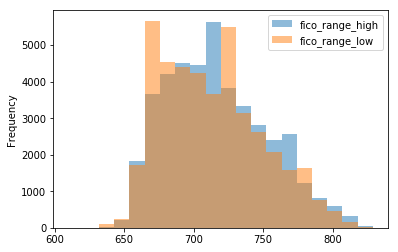

In [0]:
fico_columns = ['fico_range_high','fico_range_low']
print(loans_2007.shape[0])

loans_2007.dropna(subset=fico_columns,inplace=True) # Dropping any missing value
print(loans_2007.shape[0])

loans_2007[fico_columns].plot.hist(alpha=0.5,bins=20);

In [0]:
# Creating a new column of average of FICO ranges
loans_2007['fico_average'] = (loans_2007['fico_range_high'] + loans_2007['fico_range_low']) / 2

cols = ['fico_range_low','fico_range_high','fico_average']
loans_2007[cols].head()

,fico_range_low,fico_range_high,fico_average
0,735.0,739.0,737.0
1,740.0,744.0,742.0
2,735.0,739.0,737.0
3,690.0,694.0,692.0
4,695.0,699.0,697.0


In [0]:
# Dropping the columns which are not needed.
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low', 'last_fico_range_high']
loans_2007 = loans_2007.drop(drop_cols, axis=1)
loans_2007.shape

(42535, 33)

Here we have reduced the numbr of columns from 56 to 33 without losing any information and avoiding any data leakage problem.

## Deciding on TARGET column

In [0]:
preview[preview['name']=='loan_status']

,name,dtypes,first value,description
16,loan_status,object,Fully Paid,Current status of the loan


In [0]:
loans_2007['loan_status'].value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

Here **Fully Paid** and **Charged Off** are the only values which are important.
We can classify **Fully Paid** as 1 and **Charged Off** as 0.

In [0]:
loans_2007 = loans_2007[(loans_2007['loan_status'] == 'Fully Paid') | (loans_2007['loan_status'] == 'Charged Off')]

mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
loans_2007 = loans_2007.replace(mapping_dictionary)

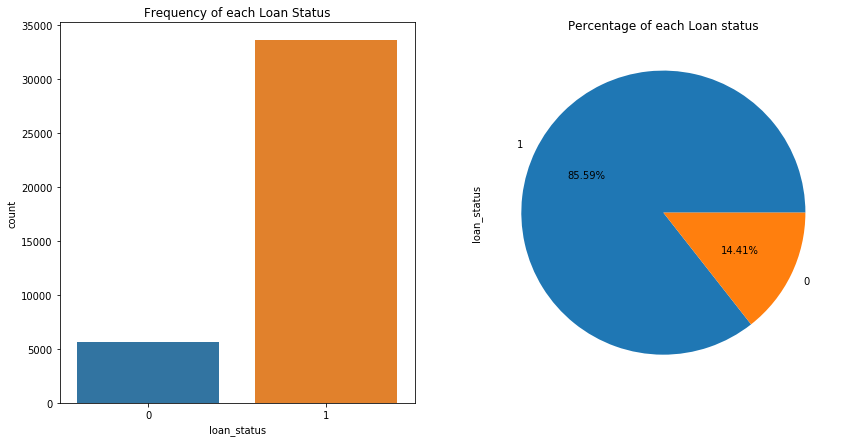

In [0]:
# Visualising the Target Coumn

fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=loans_2007,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loans_2007.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

## Remove Columns with only One Value


In [0]:
loans_2007 = loans_2007.loc[:,loans_2007.apply(pd.Series.nunique) != 1]

There may be some columns with more than one unique value, but one value that has insignificant frequency in the data set. Let’s find and drop any columns with unique values that appear fewer than four times:

In [0]:
for col in loans_2007.columns:
  if (len(loans_2007[col].unique())<4):
    print(loans_2007[col].value_counts())

 36 months    29096
 60 months    10143
Name: term, dtype: int64
Not Verified       16845
Verified           12526
Source Verified     9868
Name: verification_status, dtype: int64
1    33586
0     5653
Name: loan_status, dtype: int64
n    39238
y        1
Name: pymnt_plan, dtype: int64


Here in **pymnt_plan** we can see that value **y** has only one count. So we should remove this column.

In [0]:
print(loans_2007.shape[1])
loans_2007 = loans_2007.drop('pymnt_plan', axis=1)
print("We've been able to reduce the features to => {}".format(loans_2007.shape[1]))

25
We've been able to reduce the features to => 24


In [0]:
#Saving our transformed data.
loans_2007.to_csv("filtered_loans_2007.csv",index=False)